In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb
import sc_eVIP

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 85778 × 1224 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'uninfected', 'vbc.counts', 'batch_num18', 'batch_num8', 'batch_num25', 'batch_num22', 'batch_num24', 'batch_num28', 'batch_num27', 'batch_num23', 'batch_num17', 'batch_num19', 'batch_num12', 'batch_num31', 'batch_num5', 'batch_num15', 'batch_num7', 'batch_num9', 'batch_num4', 'batch_num2', 'batch_num13', 'batch_num6', 'batch_num26', 'batch_num16', 'batch_num10', 'batch_num1', 'batch_num29', 'batch_num0', 'batch_num11', 'batch_num30', 'batch_num3', 'batch_num14', 'batch_num21', 'batch_num20', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'G105C', 'G266E', 'G154V', 'Y220C', 'V216V', 'WT', 'M246V', 'E286K', 'C176Y', 'S366A', 'H193Y', 'L344L', 'E339K', 'P47P', 'V173M', 'V272L', 'R158H', 'C135F', 'A83V', 'L194R', 'T312S', 'S127F', 'R249S', 'R337L', 'R273H', 'V272M', 'R273L', 'Q5R', 'R249M', 

In [4]:
ref='P359P'
#methods=['HotellingT2']

#collect the variants into a list
perturb.pp.get_perturbations(adata,'guide.compact')

variants=adata.uns['PS.guide.compact.list']
variants.append('unassigned')
print(variants)
print(len(variants))

['A159P', 'A159V', 'A83V', 'C135F', 'C135Y', 'C141Y', 'C176F', 'C176Y', 'C238F', 'C238Y', 'C242F', 'C275F', 'C275Y', 'C277F', 'D21D', 'E271K', 'E285K', 'E286K', 'E2E', 'E339K', 'G105C', 'G154V', 'G244C', 'G245C', 'G245D', 'G245S', 'G245V', 'G266E', 'G266R', 'G266V', 'G360V', 'H179R', 'H179Y', 'H193L', 'H193R', 'H193Y', 'H214R', 'I195T', 'K132N', 'K132R', 'L194R', 'L344L', 'M237I', 'M246V', 'P151S', 'P152L', 'P153P', 'P222P', 'P250L', 'P278L', 'P278S', 'P295P', 'P301P', 'P359P', 'P36P', 'P47P', 'P47S', 'P58R', 'Q5R', 'R110L', 'R158H', 'R158L', 'R158R', 'R175H', 'R213Q', 'R248L', 'R248W', 'R249M', 'R249S', 'R273C', 'R273H', 'R273L', 'R280K', 'R280T', 'R282W', 'R337C', 'R337L', 'S127F', 'S241C', 'S241F', 'S366A', 'T118T', 'T170T', 'T312S', 'V157F', 'V173L', 'V173M', 'V216M', 'V216V', 'V272L', 'V272M', 'V31I', 'WT', 'Y107H', 'Y163C', 'Y205C', 'Y220C', 'Y234C', 'Y236C', 'unassigned']
100


In [5]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')

anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
impactful=list(set(list(anno.loc[anno['control_status']=='unknown',:].index)).intersection(set(variants)))
print(len(impactful))

sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
anno['cluster_color']=sorted_variants_df.loc[anno.index,1]
anno.loc['unassigned','cluster_color']='#99CCFF'

['P295P', 'P359P', 'T170T', 'L344L', 'E2E', 'P301P', 'D21D', 'P47P', 'WT', 'P36P', 'V216V', 'P153P', 'R158R', 'T118T', 'P222P']
74


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [6]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


0

In [ ]:
for pc_num in [5,10,
               20,30,40,50,
               #30,40,50
              ]:
    print('PCCCCCCCCCCC ',pc_num)
    for i in range(10):
        print('==============',i)
        for subs in [1000,500,200,100,50,#100,200,1000,#20,10,#50,40,#30,20,10,
            #1000,900,800,700,600,500,400,300,200,
            #         190,180,170,160,150,140,130,120,110,
            #         100,90,80,70,60,

        ]:

            print('cells',subs)

            out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
            cell_ids=list(pd.read_csv(out).iloc[:,0])

            #get subsample
            adata_sub=adata[cell_ids,:].copy()

            #HotellingT2 ========================================
            pcs=min(pc_num,subs-1)
            print('pcs',pcs)
            dataset=pd.DataFrame(adata_sub.obsm['X_pca'][:,:pcs],
                         index=adata_sub.obs_names,
                        columns=range(pcs))
            labels=pd.DataFrame({'label':adata_sub.obs['guide.compact']})
            labels.index=adata_sub.obs_names

            #compute scores and their FDRs
            scores_hotel=sc_eVIP.score.compare_groups_with_reference(dataset,
                                      labels,
                                     variants,
                                      syn,
                                     methods=['HotellingT2'],
                                     n_bootstrap_controls=0)

            scores_all=scores_hotel

            out=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.numPCs'+str(pc_num)+'.csv'
            scores_all.to_csv(out)

In [7]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [8]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'

for pc_num in [5,10,
               20,30,40,50,
              ]:
    for i in range(10):
        print(i)
        outs[i]={}
        for subs in [1000,500,200,100,50,
        ]:
            outs[i][subs]={}

            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.numPCs'+str(pc_num)+'.csv'
            scores_real2=pd.read_csv(out2,index_col=0)
            print(scores_real2.head())

            for fdr in [fdr_total]:

                for method in methods:

                    #all variants
                    #============
                    #get impactful variants
                    impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                    ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                    print(method,fdr,'impactful',len(impactful))

                    pre,rec=get_precision_recall(scores_real2,
                                                 method+thestat,
                                                 impactful,fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                           'PCs':pc_num,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'cluster':'all',
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                    res[method]=pd.concat([res[method],res_here])


                    #now, go through each cluster of variants and compute (vs original ctrls)
                    for cl in ['#99CCFF', 'navy']:
                        cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                        cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                        variants_here=list(set(cl_variants).union(set(ctrls)))
                        pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                                 method+thestat,
                                                 cl_variants_sig,
                                                     fdr)
                        res_here=pd.DataFrame({'cells':subs,
                                               'PCs':pc_num,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'cluster':cl,
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                        res[method]=pd.concat([res[method],res_here])
                
                
                
    

0
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R           9.864269                 7.177032                 12.551506   
R273H         58.241709                51.890322                 64.593095   
R282W        135.393279               124.970624                145.815934   
P301P          4.914483                 3.460268                  6.368697   
M246V         93.900181                84.322583                103.477779   

       HotellingT2.q  
P58R        0.299065  
R273H       0.000010  
R282W       0.000010  
P301P       0.586414  
M246V       0.000010  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R           9.737780                 6.871877                 12.603682   
R273H         30.449268                24.236871                 36.661665   
R282W         73.728974                64.905840                 82.552109   
P301P          5.078911  

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R           7.123651                 5.035436                  9.211866   
R273H         13.401418                10.225220                 16.577616   
R282W         44.241934                37.520962                 50.962905   
P301P          3.786397                 2.435034                  5.137761   
M246V         22.052246                17.588249                 26.516244   

       HotellingT2.q  
P58R        0.427706  
R273H       0.132404  
R282W       0.000010  
P301P       0.605980  
M246V       0.000010  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R           4.803451                 3.335476                  6.271427   
R273H         14.315986                11.860737                 16.771235   
R282W         27.687483                24.790105                 30.584860   
P301P          4.586224    

true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          13.929225                10.717791                 17.140658   
R273H         20.114254                16.604953                 23.623555   
R282W         55.734314                48.891701                 62.576928   
P301P          9.033004                 6.549304                 11.516703   
M246V         28.668463                24.222610                 33.114317   

       HotellingT2.q  
P58R        0.348980  
R273H       0.105923  
R282W       0.000010  
P301P       0.643041  
M246V       0.029746  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R           9.649354                 7.612010                 11.686698   
R273H         19.431162                15.482757                 23.379567   
R282W         37.456308                33.043642                 41.868973   
P301P      

true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          13.169273                 8.780493                 17.558053   
R273H         15.960938                 9.838660                 22.083216   
R282W         18.335808                14.338873                 22.332744   
P301P         11.389817                 8.058017                 14.721617   
M246V         13.532538                10.428545                 16.636532   

       HotellingT2.q  
P58R        0.554731  
R273H       0.455446  
R282W       0.473616  
P301P       0.587970  
M246V       0.551246  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
8
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          16.091067                12.905830                 19.276304   
R273H         80.658508                72.404814                 88.912201   
R282W        162.836725               151.860198                173.813252   
P301P         12.

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          24.195093                19.572706                 28.817481   
R273H         49.628873                44.509189                 54.748557   
R282W         70.152858                65.118050                 75.187666   
P301P         21.353402                17.806542                 24.900262   
M246V         34.681791                29.989893                 39.373690   

       HotellingT2.q  
P58R        0.587639  
R273H       0.038095  
R282W       0.000010  
P301P       0.619493  
M246V       0.324930  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          31.102716                26.263214                 35.942218   
R273H         39.925695                34.328128                 45.523263   
R282W         48.412334                43.643523                 53.181144   
P301P         27.172229    

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          36.479575                31.825457                 41.133693   
R273H         52.821706                47.317948                 58.325464   
R282W         72.317101                61.867040                 82.767161   
P301P         33.521385                29.752480                 37.290291   
M246V         57.695799                52.536774                 62.854824   

       HotellingT2.q  
P58R        0.552500  
R273H       0.172152  
R282W       0.000010  
P301P       0.627184  
M246V       0.069744  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          44.329118                35.938354                 52.719881   
R273H         58.465591                47.482601                 69.448582   
R282W         68.891992                54.047150                 83.736835   
P301P         42.721649    

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          49.236640                41.072077                 57.401203   
R273H        146.834794               133.462956                160.206631   
R282W        218.003869               200.135473                235.872265   
P301P         40.270003                35.265388                 45.274617   
M246V        156.199976               142.334711                170.065240   

       HotellingT2.q  
P58R        0.207519  
R273H       0.000010  
R282W       0.000010  
P301P       0.461937  
M246V       0.000010  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          33.601083                30.067103                 37.135063   
R273H         92.325652                85.209759                 99.441546   
R282W        106.314615                99.206846                113.422384   
P301P         41.378280    

true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          48.401228                42.240051                 54.562404   
R273H        147.205373               133.703689                160.707058   
R282W        184.632277               171.040504                198.224050   
P301P         31.877947                28.500337                 35.255557   
M246V        174.664830               160.891721                188.437940   

       HotellingT2.q  
P58R        0.355718  
R273H       0.000010  
R282W       0.000010  
P301P       0.646370  
M246V       0.000010  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          41.094699                34.715783                 47.473616   
R273H         83.788667                73.218993                 94.358340   
R282W         87.450759                77.411428                 97.490090   
P301P      

true 60
0
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          70.874262                63.363183                 78.385341   
R273H        251.937933               229.297721                274.578145   
R282W        390.228861               362.645116                417.812605   
P301P         57.123250                51.066991                 63.179510   
M246V        281.065954               259.613801                302.518108   

       HotellingT2.q  
P58R        0.276468  
R273H       0.000010  
R282W       0.000010  
P301P       0.520238  
M246V       0.000010  
HotellingT2 0.05 impactful 75
true 75
true 14
true 60
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
P58R          67.132063                57.176330                 77.087795   
R273H        167.448513               150.937911                183.959115   
R282W        236.968037               219.425592                254.510483   
P301P         51.

FileNotFoundError: [Errno 2] File b'/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/scores/scores.iter5.cells1000.cells.numPCs50.csv' does not exist: b'/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/scores/scores.iter5.cells1000.cells.numPCs50.csv'

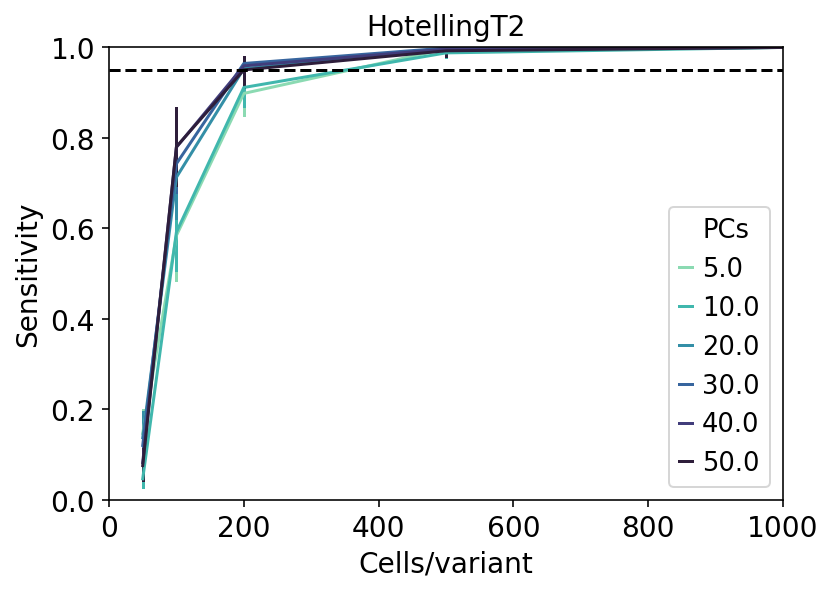

In [14]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='PCs', 
    #cmap='tab20',
    err_style="bars",
    palette=sns.color_palette("mako_r", 6),
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.png',bbox_inches = "tight")
plt.show()

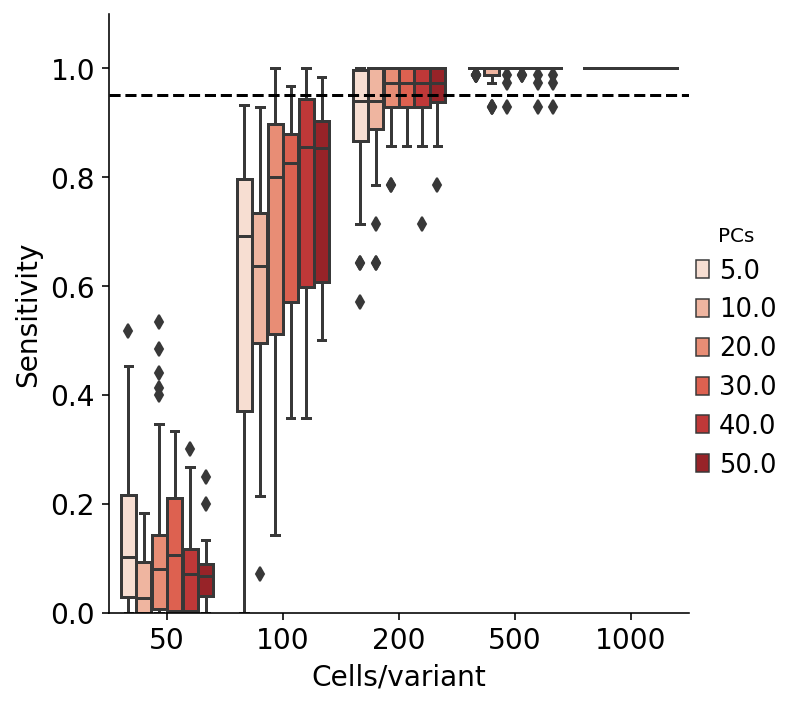

In [24]:
#how to make lines with error bars
method='HotellingT2'

sns.catplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='PCs', kind='box',
    #cmap='tab20',
    #err_style="bars",
    palette=sns.color_palette("Reds", 6),
    #ci=95,
)
plt.ylim(0,1.1)
#plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.png',bbox_inches = "tight")
plt.show()

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)

def compare_two_groups(adata_here,
                       grouping_variable,
                       g1,g2,
                       methods=['HotellingT2','avg.pearson','avg.spearman','avg.L1'],
                       num_pcs_hotelling=20):
    
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    g1_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g1]
    g2_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g2]
    
    comparison_name=g1+'.VS.'+g2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,g1_cells,g2_cells,method)
        else:
            v=compare_2_groups_df(data_here,g1_cells,g2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=g1
        df_comparison.loc[comparison_name,'group2']=g2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)

def get_conf_interval(data,ci_size=0.95):
    from scipy.stats import t, sem

    #create 95% confidence interval for population mean weight
    ci1,ci2=t.interval(alpha=ci_size, df=len(data)-1, 
               loc=np.mean(data), scale=sem(data)) 
    return(ci1,ci2)

#convert our scores to empirical p-values
def empirical_pvalues(values_df,empirical_dist):
    
    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5):
    plt.hist(ps,30)
    plt.show()
    thresh=0.5
    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    to_return={}
    
    for method in methods:
        res_combo=pd.concat([res_true.loc[:,['dataset','group2',method]],
                             res_perm.loc[:,['dataset','group2',method]]],axis=0)
        min_fdr=1.0/res_combo.shape[0]
        print('min fdr',min_fdr,res_combo.shape)
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr)) 
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
        to_return[method]=res_combo.loc[res_combo['dataset']=='true data',:]
        to_return[method]=to_return[method].drop(columns=['dataset'])
        to_return[method].index=list(to_return[method]['group2'])
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()
            
    return(to_return)


def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=20):
    
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
    
    import copy
    followup=copy.deepcopy(groups)
    for c in controls_for_ci_found:
        followup.append(c)
    followup=list(set(followup))
    counter=0
    for group in followup:
        counter+=1
        perturb.util.display_progress(counter,len(followup))
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        if len(controls_for_ci_found)>0:
            control_scores={}
            #get scores for each control, so we can compute a confidence interval
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = emp_scores[~np.isnan(emp_scores)]
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method],emp_scores)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [ ]:
#### works




def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['avg.pearson'],
                                 num_pcs_hotelling=20):
    
    #checks 
    import copy
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
  
  
    #for storing results
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    #total list of groups to test = groups + ones for CI
    totest=list(set(groups).union(set(controls_for_ci_found)))
    
    #go through each test
    counter=0
    for group in totest:
        counter+=1
        perturb.util.display_progress(counter,len(totest))
        
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        
        #test group vs reference
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        #compute CI for this group
        if len(controls_for_ci_found)>0:
            control_scores={}
            #score against each control
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
                    
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
    
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method+'.ci.'+str(ci_size)+'.mean'],emp_scores)
        print('computed ps===',emp_p)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [ ]:
def empirical_pvalues(values_df,empirical_dist):

    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5,thresh=0.5):

    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)


def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)


def df_to_CI(res_df,score_cols,controls,control_col='group2',test_col='group1',ci_size=0.95):
    
    res_df.index=range(res_df.shape[0])
    groups=list(set(res_df[test_col]))
    res_cols=[]
    for score_col in score_cols:
        res_cols.append(score_col+'.mean')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.low')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.high')
        
    res_ci=pd.DataFrame(index=groups,columns=res_cols)
    for score_col in score_cols:
        for group in groups:
            rows=list(set(list(res_df.loc[res_df[test_col]==group,:].index)).intersection(set(list(res_df.loc[res_df[control_col].isin(controls),:].index))))
            group_scores=res_df.loc[rows,score_col]
            conf_intervals=get_conf_interval(group_scores,ci_size=ci_size)
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
            res_ci.loc[group,score_col+'.mean']=np.mean(group_scores)
    return(res_ci)

def get_empirical_q(res_full,res_ci,
                    controls,
                    score_cols,
                    control_col='group2',test_col='group1'):

    for score_col in score_cols:
        
        rows1=list(res_full.loc[res_full[control_col].isin(controls),:].index)
        rows2=list(res_full.loc[res_full[test_col].isin(controls),:].index)
        rows=list(set(rows1).intersection(set(rows2)))
        
        emp_scores=np.array(res_full.loc[rows,score_col].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        
        #q-values
        emp_p=empirical_pvalues(res_ci[score_col+'.mean'],emp_scores)
        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        res_ci[score_col+'.q']=qvalue(np.array(emp_p_combo))[:res_ci.shape[0]]
    return(res_ci)

def display_progress(cur_num,max_num):
    sys.stdout.write('\r'+str(int(100*(1.0*cur_num/max_num)))+' %')
    sys.stdout.flush()

def compare_groups_with_reference(data_df,
                                  labels_df,
                                 groups,
                                  controls,
                                 methods=['HotellingT2','avg.pearson'],
                                 n_bootstrap_controls=0,
                                 rng=np.random.RandomState(1234)):
    
    import copy
    groups_found=list(set(labels_df['label']))
    controls_found=list(set(groups_found).intersection(set(controls)))
    if len(controls_found)>0:
        print('Found '+str(len(controls_found))+'/'+str(len(controls_found))+' controls')
    else:
        print('ERROR: No controls found.')
        return()
    
    #setup result data
    res_col=['group1','group2']
    for c in methods:
        res_col.append(c)
    res=pd.DataFrame(columns=res_col)
    
    #score groups against all controls, and all controls against all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_found,columns=groups_found)
        
    #get group cells 
    group_cells_d={}
    for group in groups:
        if group not in groups_found:
            print('WARNING: group "'+group+'" is not in label data frame. Skipping')
            return
        group_cells=list(labels_df.loc[labels_df['label']==group].index)
        group_cells_d[group]=group_cells
        
    #get control cells
    control_cells_d={}
    controls_found_plus_bootstraps=[]
    for control in controls_found:
        controls_found_plus_bootstraps.append(control)
        control_cells=list(labels_df.loc[labels_df['label']==control].index)
        control_cells_d[control]=control_cells
        #if bootstrapping, sample with replacement from the control cells
        for b in range(n_bootstrap_controls):
            control_cells_d[control+'boot'+str(b)]=rng.choice(control_cells,size=len(control_cells))
            controls_found_plus_bootstraps.append(control+'boot'+str(b))
        
    #score groups against all controls
    counter=0
    for group in groups:
        group_cells=group_cells_d[group]
        counter+=1
        display_progress(counter,len(groups_found))
        
        for control in controls_found_plus_bootstraps:
            if control==group:
                continue
            #group is a test group and control is a bootstrapped one, skip test
            if group not in controls_found and control not in controls_found:
                continue
            control_cells=control_cells_d[control]
            res_here=pd.DataFrame({'group1':[group],
                                  'group2':[control]},index=[group+'.'+control])
            
            for method in methods:
                method_score=compare_2_groups_df(data_df.loc[list(set(group_cells).union(set(control_cells))),:],
                     group_cells,control_cells,
                     method)
                
                res_here[method]=method_score    
        
            res=pd.concat([res,res_here],axis=0,sort=True)
    res.index=list(res['group2'])
    
    #make confidence intervals
    res_ci=df_to_CI(res,methods,
                    controls_found_plus_bootstraps,
                    control_col='group2',
                    test_col='group1',
                    ci_size=0.95)
    
    #get qvalues from empirical p-values
    res_ci=get_empirical_q(res,res_ci,
                    controls=controls_found_plus_bootstraps,
                    control_col='group2',test_col='group1',
                    score_cols=methods)
    
    return(res_ci)
        
 

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['avg.pearson'],
                                 n_bootstrap_controls=1)       

In [ ]:
dataset=pd.DataFrame(adata.obsm['X_pca'][:,:20],
                     index=adata.obs_names,
                    columns=range(20))
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [ ]:
res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['HotellingT2'],
                                 n_bootstrap_controls=1) 

In [ ]:
x=res_out

In [ ]:
x.loc[syn,:]

In [ ]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


res={}
outs={}
methods=['HotellingT2','avg.pearson','avg.L1']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP'])
    

    


In [ ]:
for i in range(1):
    outs[i]={}
    for subs in [1000,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
                
    ]:
        outs[i][subs]={}
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()

        #compute scores and their FDRs
        scores_real2=compare_groups_with_reference(adata_sub,
                                  grouping_variable='guide.compact',
                                 groups=variants,
                                 reference=ref,
                                  controls_for_ci=syn,
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=min(20,subs-1))[0]

        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2.to_csv(out2)

In [ ]:
outs[0].loc[syn,:]

In [ ]:
method='HotellingT2'
empirical_pvalues(outs[1][method].loc['P359P',syn],outs[3][method])

In [ ]:
outs[3][method]

In [ ]:
outs[3][method].sort()
print(outs[3][method])

In [ ]:
vs=list(outs[0][method].index)
print(ps)
ps=pd.DataFrame({'p':list(ps)},index=vs)

In [ ]:
ps.loc[syn]

In [ ]:
outs[1][method].loc['P359P',syn].sort_values()

In [ ]:
qvalue(ps)

In [ ]:
scores.head()

In [ ]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [ ]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'
for i in range(3):
    print(i)
    outs[i]={}
    for subs in [1000,200,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)
        print(scores_real2.head())

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                print(method,fdr,'impactful',len(impactful))
                
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                '''
                #now, go through each cluster of variants and compute (vs original ctrls)
                for cl in ['#99CCFF', 'navy']:
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    res[method]=pd.concat([res[method],res_here])
                '''
                
    

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

In [ ]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    print('new')
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)


subs_list=[1000,900,800,700,600,500,400,300,200,100,50]


methods=['HotellingT2','avg.pearson']
for method in methods:
    SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
    scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
    scores=pd.read_csv(scorefile,header=0,index_col=0)
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=[method+'.ci.0.95.mean'],ascending=True)

    fig,plots=plt.subplots(len(subs_list),1)
    fig.set_size_inches(5,10)
    c=0
    for subs in subs_list:

        SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
        scorefile=SCORE_DIR+'/scores.iter0.cells'+str(subs)+'.cells.csv'
        scores=pd.read_csv(scorefile,header=0,index_col=0)        

        w=10
        h=6
        
        plot_with_errorbars(list(anno.index),
                            scores.loc[anno.index,method+'.ci.0.95.mean'],
                           scores.loc[anno.index,method+'.ci.0.95.low'],
                           scores.loc[anno.index,method+'.ci.0.95.high'],
                            plots=plots[c],
                            flip_axes=False,
                            color_lines=list(anno.loc[anno.index,'cluster_color']),

                            s=5,
                           c=list(anno.loc[anno.index,'cluster_color']))

        if method=='avg.pearson':
            plots[c].set_ylabel('1 - Pearson correlation\n(variant vs WT)')
            #plots[c].set_ylim(0,1.5)
            #plots[c].set_yticks([0,0.5,1.0,1.5])
        if method=='HotellingT2':
            plots[c].set_ylabel('HotellingT2')
            #plots.set_ylim(0,1.5)
            #plots.set_yticks([0,0.5,1.0,1.5])
        plots[c].set_xticklabels([])
        plots[c].set_xlim(-1,101)

        #figure out FDR line
        #thresh=get_threshold_at_FDR(scores,method,statname='.q',FDR=0.05)
        #plots[c].axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
        plots[c].set_title(str(subs))
        c+=1
    plt.show()

Analyze scores as a function of number of PCs
===

In [ ]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)

            out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
            cell_ids=list(pd.read_csv(out).iloc[:,0])

            #get subsample
            adata_sub=adata[cell_ids,:].copy()

            #compute scores and their FDRs
            scores_real2=compare_groups_with_reference(adata_sub,
                                      grouping_variable='guide.compact',
                                     groups=variants,
                                     reference=ref,
                                      controls_for_ci=syn,
                                      ci_size=0.95,
                                     methods=['HotellingT2','avg.pearson'],
                                     num_pcs_hotelling=min(pc,subs-1))[0]

            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2.to_csv(out2)

In [ ]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)

In [ ]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)
            
            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2=pd.read_csv(out2,index_col=0)

            for fdr in [fdr_total]:

                for method in methods:

                    #all variants
                    #============
                    #get impactful variants
                    impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                    ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                    print(method,fdr,'impactful',len(impactful))

                    pre,rec=get_precision_recall(scores_real2,
                                                 method+thestat,
                                                 impactful,fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'pc':pc,
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                    res[method]=pd.concat([res[method],res_here])
            
            

In [ ]:
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='pc', 
    #cmap='tab20',
    err_style="bars",
    
    ci=68,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()



In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='pc', 
    #cmap='tab20',
    #err_style="bars",
    ci=68,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()

In [ ]:
plt.plot(adata.uns['pca']['variance']/adata.n_vars*100,
        color='black')
plt.axvline(x=20,color='red',linestyle='--')
plt.xlabel('PC')
plt.ylabel('Percent variance explained')
plt.grid(False)

In [ ]:
adata.uns['pca']['variance']/adata.n_vars*100

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==0.01,:], 
    x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method], x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()


In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]

In [ ]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.sort_values(by=['control_status2',method+'.ci.0.95.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.ci.0.95.mean'],
                        #scores.loc[anno.index,method],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[:,'text_color']),

                        s=10,
                       c=list(anno.loc[:,'text_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=30.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,1.5)
        plots.set_yticks([0,0.5,1.0,1.5,2.0])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,28,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,method,statname='.FDR',FDR=0.05)
    print('thresh',thresh)
    plt.axhline(y=thresh,color='black',linestyle='--')
    plt.show()

In [ ]:
scores.loc[syn,:].sort_values(by='HotellingT2.ci.0.95.mean')

In [ ]:
scores.loc[syn,].sort_values(by='HotellingT2.q')